# Assignement 2

In this assignement we are looking at the aurora borealis and how the magnetic field of the earth can create this effect. To do this we are modelling the earth as a magnetic dipole and sending a charged particle from the sun at it.


In [18]:
# Imports used throughout the project

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## 1) Modelling the earth as a magnetic dipole

First we need to know the magnetic field around the earth, we can here use a simplification and model it as a magnetic dipole.

The magnetic field created by a dipole can be written as:

$$
B_{dip}(\bold{r}) = \frac{\mu_{0}}{4\pi}\frac{1}{r^3}[3(\bold{m}\cdot\bold{\hat{r}})\bold{\hat{r}}-\bold{m}]
$$

where r is the length of $\bold{r}$ and $\bold{m}$ is the magnetic dipole moment.

We then write the function:

In the case of the earth the magnitude of the magnetic diople is roughly $6.4\cdot 10^{22} Am^2$, see [Harvard](https://sciencedemonstrations.fas.harvard.edu/presentations/earths-magnetic-field). This means we can write $\bold{m} = |{\bold{m}}| \bold{\hat{m}}$, and only need the direction the magnetic moment is pointing. 

To find $\bold{\hat{m}}$ we first have to define our coordinate system. In this project we will have the x-axis pointing towards the the sun from the center of the earth, the z-axis will point straight up from the x-axis and the y-axis will go out of the screen. 
We then have to account for the tilt of the earth, and the fact that the magnetic north pole is not at the north pole. The eventual particle we will simulate should move so fast that we need not account for the rotation of the earth around the sun or its own axis. We will therefore choose a moment in time for which the north pole is tilted 23.5 degrees towards the sun, from the z-axis using spherical coordinates, and the magnetic north pole is 11 degrees towards the sun from the north pole again.
This means the angle of the magnetic moment will be $\theta = 34.5 \degree$ and in cartesian coordinates it will have only components in the z and x direction.

As $\bold{\hat{m}}$ has a magnitude of 1 we can write $\bold{m}$  as


$$
\bold{m} = |\bold{m}|\bold{\hat{m}} = 6.4 \cdot 10^{22} (sin(34.5 \degree)\hat{x} + cos(34.5 \degree) \hat{z})
$$

Finally we can write the function for the B-field:

In [19]:
mu_0 = 1.2e-6
m = 6.4*10**22 * np.array([np.sin(np.radians(34.5)), 0, np.cos(np.radians(34.5))]) 


def get_B_field(pos): 
    r_vec = np.array(pos)
    r = np.linalg.norm(pos)
    r_hat = r_vec/r
    B_vec = mu_0/(4*np.pi) * (3 * ( np.dot(m,r_hat))*r_hat - m)/r**3
    return B_vec


First we approximate the earths magnetic field to a dipole, using a formula from Griffits. We can replace the magnetic moment with its unit vector and a constant for the B-field. We set B_0 from the wikipedia page for the earth as a dipole.

We then plot the magnetic field in xy and xz plane.

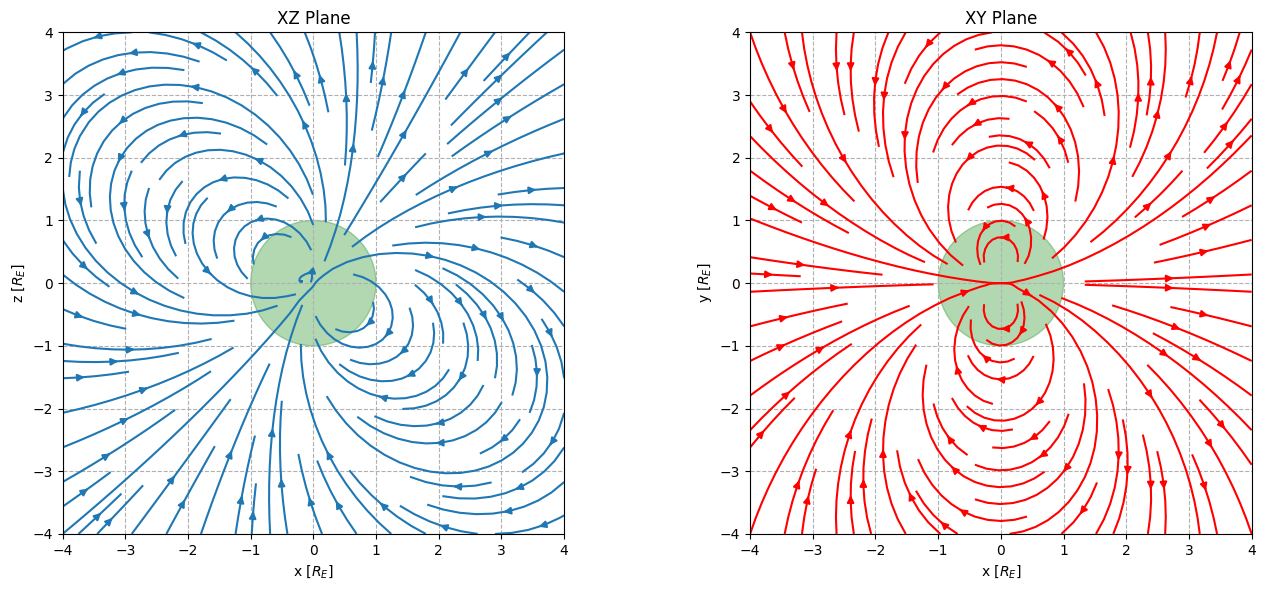

In [20]:
Re = 6371e3 # Using the earths radius to make the plots cleaner

limit = 4 * Re
points = 50
coords = np.linspace(-limit, limit, points)
X_grid, Z_grid = np.meshgrid(coords, coords)

Bx_xz = np.zeros_like(X_grid)
Bz_xz = np.zeros_like(Z_grid)

Bx_xy = np.zeros_like(X_grid)
By_xy = np.zeros_like(Z_grid)

# Calculate field at each point
for i in range(points):
    for j in range(points):
        b_xz = get_B_field(np.array([X_grid[i,j], 0, Z_grid[i,j]]))
        Bx_xz[i,j], Bz_xz[i,j] = b_xz[0], b_xz[2]
        
        b_xy = get_B_field(np.array([X_grid[i,j], Z_grid[i,j], 0]))
        Bx_xy[i,j], By_xy[i,j] = b_xy[0], b_xy[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# XZ Plane
ax1.streamplot(X_grid/Re, Z_grid/Re, Bx_xz, Bz_xz)
ax1.add_patch(plt.Circle((0, 0), 1, color='green', alpha=0.3, label='Earth'))
ax1.set_title("XZ Plane")
ax1.set_xlabel("x [$R_E$]")
ax1.set_ylabel("z [$R_E$]")

# XY Plane 
ax2.streamplot(X_grid/Re, Z_grid/Re, Bx_xy, By_xy, color='red')
ax2.add_patch(plt.Circle((0, 0), 1, color='green', alpha=0.3))
ax2.set_title("XY Plane")
ax2.set_xlabel("x [$R_E$]")
ax2.set_ylabel("y [$R_E$]")

for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

## 2) Simulating the solar wind

Now we are simulating solar wind as charged particles, more precisely we are looking at a proton traveling towards the earth at some initial speed.
To find its trajectory we are using Implicit Eulers method. To use this we first need to know the acceleration the proton would experience.
This can be found through the Lorentz force.

$$
F = q v \times B
$$

where q is the charge of the particle, v is the speed and B is the magnetic field at its position.

Using Newtons second we can then find the acceleration

$$
a = q \frac{v \times B}{m_p}
$$



Implicit Euler tells us that in our case

$$
v_{n+1} = v_n + a(r_n) \cdot dt
$$
$$
r_{n+1} = r_n + v_{n+1} \cdot dt
$$

where r is the postion of the particle and dt is a small quantity.

This can then be made into a function:


In [21]:
e = 1.6e-19
m_p = 1.67e-27

def euler_solve_ivp(pos, v, dt):
    B = get_B_field(pos)
    a = e * np.cross(v, B) / m_p
    v_new = v + a * dt
    pos_new = pos + v_new * dt
    return pos_new, v_new



We then model the proton with initially constant velocity towards the earth on the x-axis. It starts one earth radius away from the earth.
We also take a look at task three while doing this, which ask us to find a test condition to estimate the accuracy of our solution.
The magnetic field shold not do any work on the particle, and as it is the only force that is relevant (we ignore gravity as it will affect little) this means the enegry should be constant. This translates to the speed of the particle being constant.

In [ ]:
# Initial Conditions
pos = np.array([-2*Re, 0, 0]) 
v = np.array([4_00_000, 0, 0])  
t_end = 10
dt = 1e-5
t_eval = np.arange(0,t_end,dt)
                  


trajectory = [pos]
speed = []

for t in t_eval:
    pos, v = euler_solve_ivp(pos, v, dt)

    trajectory.append(pos)

    speed.append(np.linalg.norm(v))

trajectory = np.array(trajectory)


-12742000.0 -14849303.235608593


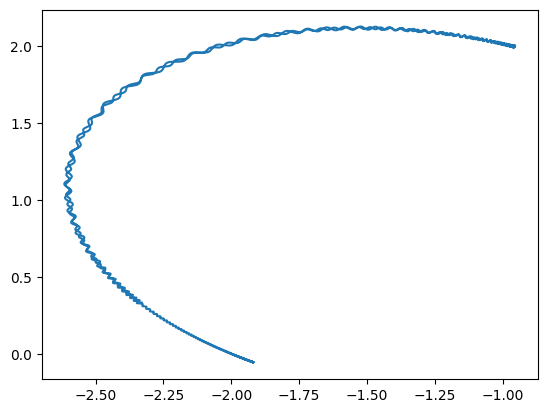

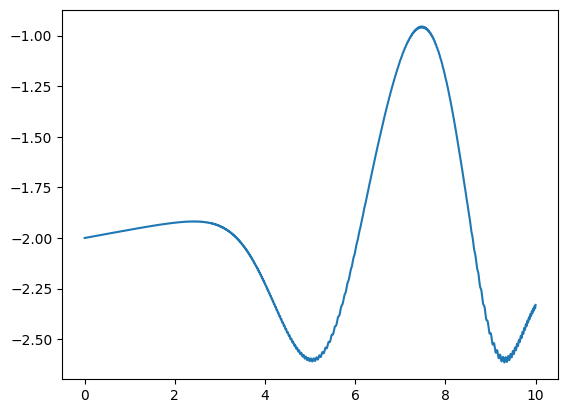

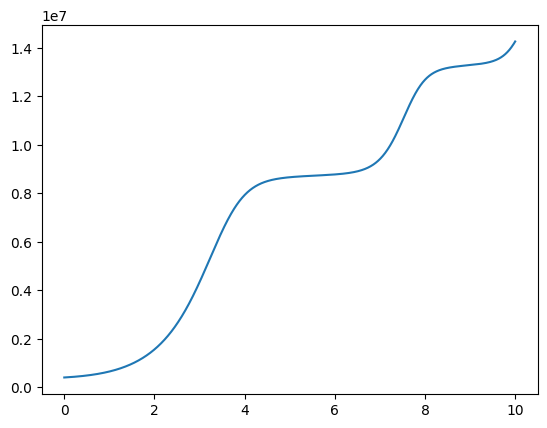

In [25]:
x,y,z = trajectory[:,0],trajectory[:,1],trajectory[:,2]
print(x[0],x[-1])
plt.plot(x/Re, z/Re)
plt.show()
plt.plot(t_eval,x[:-1]/Re)
plt.show()
plt.plot(t_eval,speed)


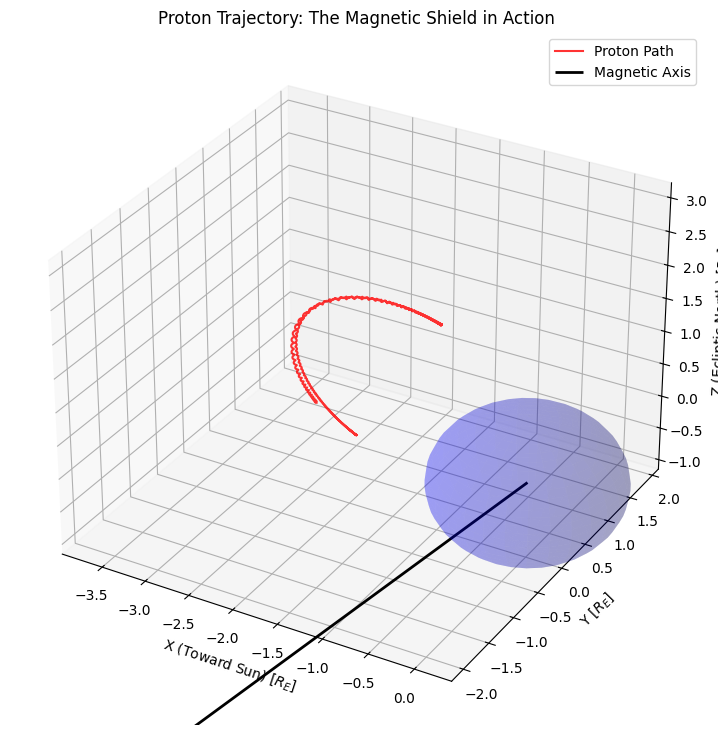

In [24]:
def plot_trajectory_fixed(trajectory, m_hat):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # 1. Plot the Trajectory
    ax.plot(trajectory[:, 0]/Re, trajectory[:, 1]/Re, trajectory[:, 2]/Re, 
            label='Proton Path', color='red', linewidth=1.5, alpha=0.8)

    # 2. Draw Earth as a sphere
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x_earth = np.outer(np.cos(u), np.sin(v))
    y_earth = np.outer(np.sin(u), np.sin(v))
    z_earth = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_earth, y_earth, z_earth, color='blue', alpha=0.2)

    # 3. Draw the Magnetic Dipole Axis
    ax.quiver(0, 0, 0, m_hat[0]*1.5, m_hat[1]*1.5, m_hat[2]*1.5, 
              color='black', label='Magnetic Axis', linewidth=2)

    # FIXED: Corrected label methods
    ax.set_xlabel('X (Toward Sun) [$R_E$]')
    ax.set_ylabel('Y [$R_E$]')
    ax.set_zlabel('Z (Ecliptic North) [$R_E$]') # No underscore after 'z'
    
    # Set equal scale
    max_range = np.array([trajectory[:,0].max()-trajectory[:,0].min(), 
                         trajectory[:,1].max()-trajectory[:,1].min(), 
                         trajectory[:,2].max()-trajectory[:,2].min()]).max() / (2.0 * Re)
    
    mid_x = (trajectory[:,0].max()+trajectory[:,0].min())/(2.0*Re)
    mid_y = (trajectory[:,1].max()+trajectory[:,1].min())/(2.0*Re)
    mid_z = (trajectory[:,2].max()+trajectory[:,2].min())/(2.0*Re)
    
    ax.set_xlim(mid_x - 2*max_range, mid_x + 2*max_range)
    ax.set_ylim(mid_y - 2*max_range, mid_y + 2*max_range)
    ax.set_zlim(mid_z - 2*max_range, mid_z + 2*max_range)

    ax.set_title('Proton Trajectory: The Magnetic Shield in Action')
    ax.legend()
    plt.show()

plot_trajectory_fixed(trajectory, m)